In [1]:
import zipfile
import numpy as np
import torch
import io
import os
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim import lr_scheduler
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score

The Convolutional Neural Network (CNN) provided below is designed for the classification of Remote Sensing (RS) satellite images (5631 images) into four distinct classes. The dataset comprises a mixture of images captured by various sensors and snapshots from Google Maps. The target classes include:

- Cloudy
- Desert
- Green Area
- Water

To enhance the model's performance, it incorporates essential techniques such as batch normalization, max-pooling, and dropout with a ratio of 0.7. Additionally, the Rectified Linear Unit (RELU) serves as the activation function. Due to memory constraints, the input images are resized to dimensions of 64x64 pixels.

In [2]:
'''
    The following are functions for the CNN. Note that the CNN structure needs to be updated
    when the image sizes are changed. 
'''

# Function 0
def calculate_accuracy(predictions, targets):
    '''
        This function evalautes the accurcay
    '''
    correct = (predictions == targets).sum().item()
    total = len(targets)
    return correct / total

# FUNCTION 1
def calculate_rmse(predictions, targets):
    '''
        This function calculates the RMSE
    '''
    return torch.sqrt(((predictions.float() - targets.float()) ** 2).mean())

# FUNCTION 2
def load_and_resize_images(zip_file_path, target_size=(250, 250)):
    '''
        This function reads the data zip file, ensures that images are 
        RGB (3 dimensional) and are 250x250 pixels.

        @zip_file_path is the dataset zip file directory
        @target_size is fixed at 250x250 since the dataset does not have larger 
        size images
    '''
    images = []
    labels = []
  
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.endswith(".jpg"):
                # Extract image data
                image_data = zip_ref.read(file_info.filename)

                # Get label from folder name
                label = os.path.dirname(file_info.filename)

                # Convert image data to PIL Image, convert to RGB, and resize
                image = Image.open(io.BytesIO(image_data)).convert('RGB')
                resized_image = image.resize(target_size)

                # Append image and label
                images.append(np.array(resized_image))  # Convert to NumPy array
                labels.append(label)
        
    return np.array(images), np.array(labels)

# FUNCTION 3
def reduce_data(images, labels, target_size=(64, 64), subset_ratio=1):
    '''
        This function reduced the images size to 64x64 pixels. The user can also
        set a subset ratio; that is the ratio of iamge samples from the whole data set
        when the dataset is very large

        @images is the image data
        @labels is the labels for the image data
        @target_size is fixed at 64x64 pixels
        @subset_ratio is ratio of the sample of the whole data set, by default it is 1 (whole dataset)
    '''
    reduced_images = []
    reduced_labels = []
    
    # Sample a subset
    subset_indices = random.sample(range(len(images)), int(subset_ratio * len(images)))

    for i in subset_indices:
        # Resize images
        resized_image = Image.fromarray(images[i]).resize(target_size)
        reduced_images.append(np.array(resized_image))
        reduced_labels.append(labels[i])

    return np.array(reduced_images), np.array(reduced_labels)

# CLASS 1
class SimplifiedCNN(nn.Module):
    ''' 
        Build a simple CNN model for 64x64 pixel images.
    '''
    def __init__(self):
        super(SimplifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.dropout = nn.Dropout(0.7)  # Adjust dropout rate
        self.fc2 = nn.Linear(64, len(label_encoder.classes_))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [3]:
# Load and resize images from the zip file
zip_file_path = 'archive.zip'
images, labels = load_and_resize_images(zip_file_path)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

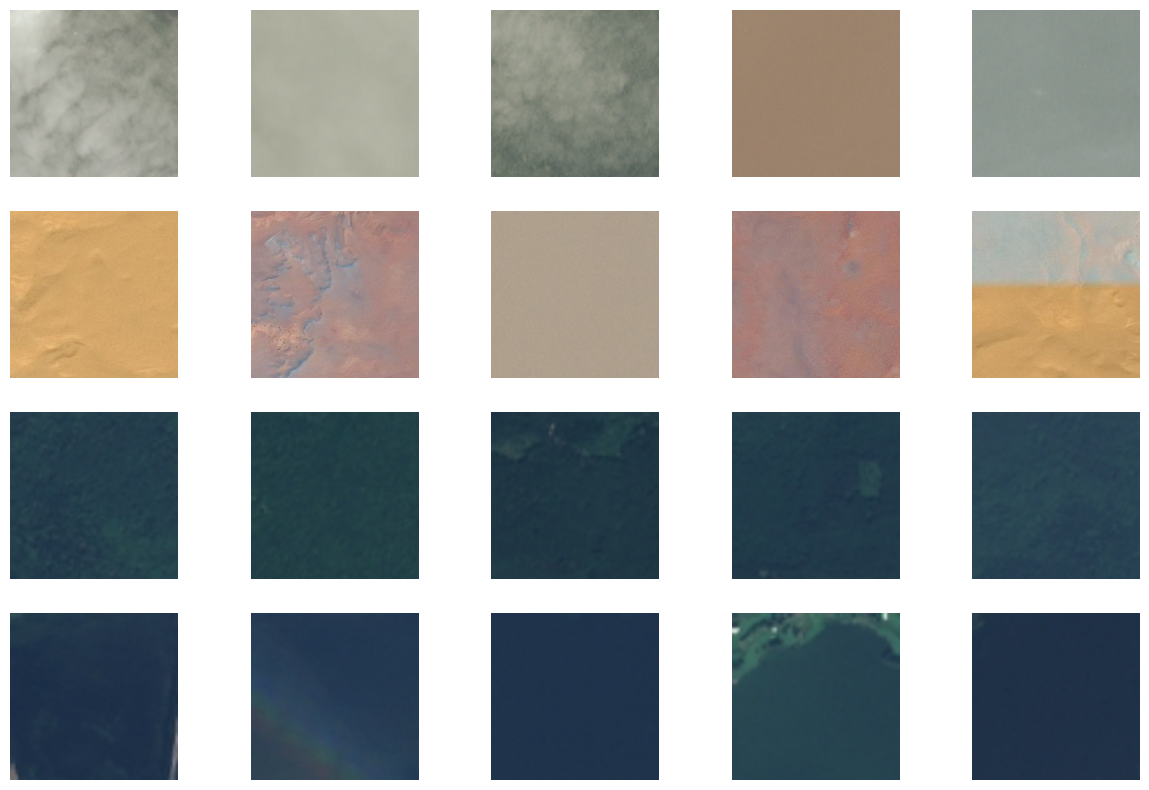

In [4]:
# Sample 4 labels for visualization
sample_labels = np.unique(y_train)[:4]

# Display 4x5 grid with each row representing a sample of a specific label
num_rows = len(sample_labels)
num_columns = 5

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))
for i, label in enumerate(sample_labels):
    # Select fixed number of samples (e.g., 5) for the current label
    samples_for_label = X_train[y_train == label][:5]

    # Display the samples in the current row
    for j in range(num_columns):
        axes[i, j].imshow(samples_for_label[j])
        axes[i, j].axis('off')

plt.show()

In [5]:
# Reduce data
X_train_reduced, y_train_reduced = reduce_data(X_train, y_train)
X_test_reduced, y_test_reduced = reduce_data(X_test, y_test)

# Encode labels for the test set
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_reduced)
y_test_encoded = label_encoder.transform(y_test_reduced)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train_reduced.transpose((0, 3, 1, 2)))  # Transpose to match PyTorch channel-first format
y_train_tensor = torch.Tensor(y_train_encoded).long()

X_test_tensor = torch.Tensor(X_test_reduced.transpose((0, 3, 1, 2)))  # Transpose to match PyTorch channel-first format
y_test_tensor = torch.Tensor(y_test_encoded).long()

# Instantiate the simplified model
simplified_model = SimplifiedCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simplified_model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [6]:
# Lists to store training and testing losses and metrics
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

# Train the model
num_epochs = 120

for epoch in range(num_epochs):
    simplified_model.train()

    optimizer.zero_grad()
    output = simplified_model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Compute and store training metrics
    predicted_train = torch.argmax(output, 1).numpy()
    y_train_np = y_train_tensor.numpy()
    train_accuracy.append(calculate_accuracy(predicted_train, y_train_np))

    # Store training loss
    train_losses.append(loss.item())

    # Evaluate the model on the test set
    simplified_model.eval()
    with torch.no_grad():
        test_output = simplified_model(X_test_tensor)
        test_loss = criterion(test_output, y_test_tensor)
        test_losses.append(test_loss.item())

        # Compute and store testing metrics
        predicted_test = torch.argmax(test_output, 1).numpy()
        y_test_np = y_test_tensor.numpy()
        test_accuracy.append(calculate_accuracy(predicted_test, y_test_np))

    # Print and plot the losses and metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, '
          f'Train Accuracy: {train_accuracy[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.4f}')

# Calculate overall accuracy
# overall_train_accuracy = correct_train_predictions / total_train_samples
# overall_test_accuracy = correct_test_predictions / total_test_samples

# print(f'Overall Training Accuracy: {overall_train_accuracy * 100:.2f}%')
# print(f'Overall Testing Accuracy: {overall_test_accuracy * 100:.2f}%')


Epoch [1/120], Train Loss: 1.4344, Test Loss: 8.8000, Train Accuracy: 0.2196, Test Accuracy: 0.2910
Epoch [2/120], Train Loss: 1.8944, Test Loss: 3.2371, Train Accuracy: 0.4867, Test Accuracy: 0.3895
Epoch [3/120], Train Loss: 1.3372, Test Loss: 2.7641, Train Accuracy: 0.4831, Test Accuracy: 0.4153
Epoch [4/120], Train Loss: 1.1750, Test Loss: 2.9199, Train Accuracy: 0.5180, Test Accuracy: 0.2910
Epoch [5/120], Train Loss: 0.8902, Test Loss: 3.0837, Train Accuracy: 0.5828, Test Accuracy: 0.2910
Epoch [6/120], Train Loss: 0.8230, Test Loss: 2.6681, Train Accuracy: 0.6230, Test Accuracy: 0.3327
Epoch [7/120], Train Loss: 0.8032, Test Loss: 1.9512, Train Accuracy: 0.6312, Test Accuracy: 0.3886
Epoch [8/120], Train Loss: 0.7327, Test Loss: 1.3518, Train Accuracy: 0.6459, Test Accuracy: 0.4916
Epoch [9/120], Train Loss: 0.7111, Test Loss: 1.0595, Train Accuracy: 0.6716, Test Accuracy: 0.5306
Epoch [10/120], Train Loss: 0.6903, Test Loss: 0.9253, Train Accuracy: 0.6869, Test Accuracy: 0.5448

An overall training accuracy of 93.98% and testing accuracy of 92.72% for a simple CNN structure with 64x64 pixel images can be considered quite good. These results suggest that the model has learned patterns from the training data and is generalizing well to the unseen test data.

It's important to note that the assessment of "goodness" can depend on various factors, including the complexity of the task, the size and diversity of the dataset, and the specific requirements of the application. In many cases, achieving accuracy above 80% is considered a reasonable performance, especially for image classification tasks.

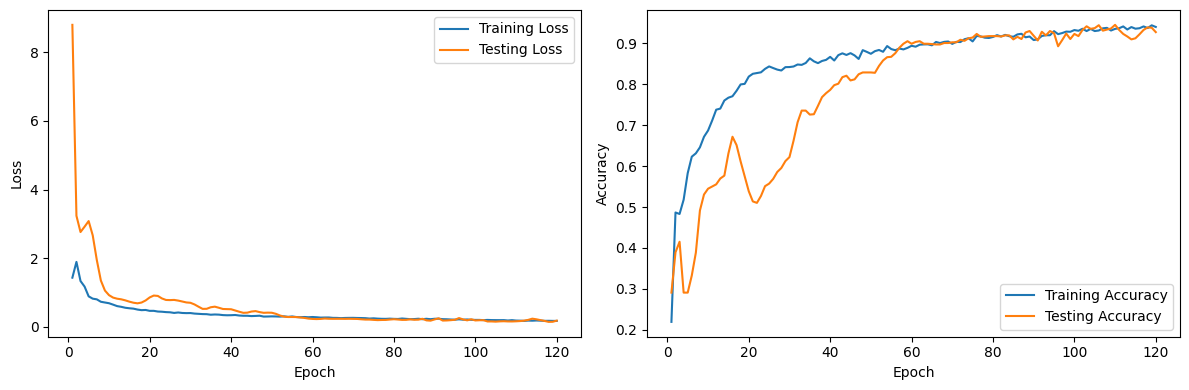

In [7]:
# Plot the training and testing losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and testing RMSE
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

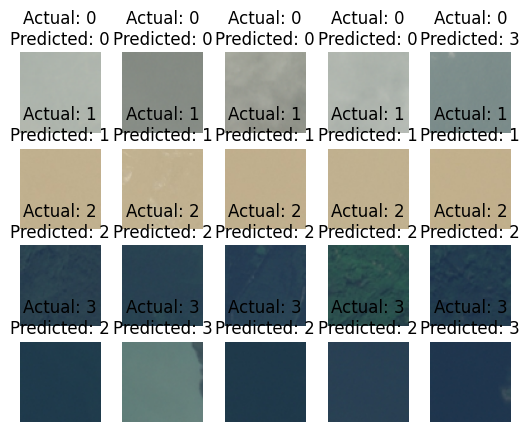

In [8]:
# Lists to store sampled indices for each class
sampled_indices_per_class = {class_name: [] for class_name in label_encoder.classes_}

# Sample 5 images for each class
for class_label in label_encoder.classes_:
    class_indices = [i for i, label in enumerate(y_test_tensor) if label.item() == label_encoder.transform([class_label])[0]]
    sampled_indices = random.sample(class_indices, min(5, len(class_indices)))
    sampled_indices_per_class[class_label] = sampled_indices

# Display actual and predicted labels for the sampled images
for class_label, sampled_indices in sampled_indices_per_class.items():
    for i, sample_index in enumerate(sampled_indices):
        sample_image = X_test_tensor[sample_index].unsqueeze(0)  # Add batch dimension

        # Make a prediction using the trained model
        simplified_model.eval()
        with torch.no_grad():
            model_output = simplified_model(sample_image)
            predicted_label = torch.argmax(model_output, 1).item()

        # Convert labels back to their original class names
        predicted_class_name = label_encoder.classes_[predicted_label]
        actual_class_name = label_encoder.classes_[y_test_tensor[sample_index].item()]

        # Normalize pixel values to [0, 1]
        sample_image_normalized = sample_image.squeeze().permute(1, 2, 0).numpy() / 255.0

        # Display the sample image, actual label, and predicted label
        plt.subplot(4, 5, i + 1 + 5 * label_encoder.transform([class_label])[0])
        plt.imshow(sample_image_normalized)
        plt.title(f'Actual: {actual_class_name}\nPredicted: {predicted_class_name}')
        plt.axis('off')

plt.show()